In [12]:
import pandas as pd
import numpy as np
import cv2
import shutil
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import torch
import warnings

warnings.filterwarnings("ignore")
from ultralytics import YOLO
import os,  yaml, torch, shutil, random

In [13]:
train_data_path    = "C:/Users/er_po/Desktop/Dataguess/ObjectDetection/data/training_images"
test_data_path  = "C:/Users/er_po/Desktop/Dataguess/ObjectDetection/data/testing_images"
train_bboxes_csv_path   = "C:/Users/er_po/Desktop/Dataguess/ObjectDetection/data/train_solution_bounding_boxes.csv"
import os
print(os.path.exists(train_bboxes_csv_path))  # True olmalı


True


In [14]:
bboxes = pd.read_csv(train_bboxes_csv_path)
len(os.listdir(train_data_path)), bboxes.shape 

(1001, (559, 5))

In [15]:
data_path = os.path.join(os.getcwd(), "data")
images_path = os.path.join(data_path, "images")
labels_path = os.path.join(data_path, "labels")

os.makedirs(images_path, exist_ok=True)
os.makedirs(labels_path, exist_ok=True)

In [16]:
class ImageReadError(Exception):
    """Custom exception for image read errors."""
    def __init__(self, message="Failed to read the image. The file might be missing or corrupted."):
        self.message = message
        super().__init__(self.message)

In [17]:
def convert_bbox_to_YOLO_format(image_path, bbox):
    try:
        image = cv2.imread(image_path)
        
        if image is None:
            raise ImageReadError(f"Failed to read image: {image_path}")

        (h, w) = image.shape[:2]
        xmin, ymin, xmax, ymax = bbox
        x_cen = (xmax + xmin) / 2. / w
        y_cen = (ymax + ymin) / 2. / h
        box_w = (xmax - xmin) / w
        box_h = (ymax - ymin) / h

        return (x_cen, y_cen, box_w, box_h)
        
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return

In [18]:
for i in range(bboxes.shape[0]):
    img_path, bbox = bboxes.loc[i, "image"], bboxes.iloc[i, 1:].values
    full_img_path = os.path.join(train_data_path, img_path)
    YOLO_format_bbox = convert_bbox_to_YOLO_format(full_img_path, bbox)
    YOLO_format_bbox = np.array(YOLO_format_bbox).astype(str)

    with open(os.path.join(labels_path, f"{img_path.replace('.jpg', '')}.txt"), "w+") as f:
        f.write("0 " + " ".join(YOLO_format_bbox) + "\n")

    shutil.copy(full_img_path, os.path.join(images_path, img_path))

In [19]:
with open(os.path.join(os.getcwd(), "dataset_custom.yaml"), "w") as f:
    f.write(f"path: {data_path}\n")
    f.write("train: images\n")
    f.write("val: images\n\n")
    f.write("nc: 1\n\n")
    f.write("names: ['car']\n")

In [ ]:
def display_image_with_bbox(image_path, bboxes, save_output=True, output_dir="output_images"):
    try:
        image = cv2.imread(image_path)

        if image is None:
            raise ValueError(f"Failed to read image: {image_path}")
        
        if bboxes:
            for bbox in bboxes:
                x1, y1, x2, y2 = map(int, bbox)
                cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        else:
            print(f"No bounding boxes for image: {image_path}")

        if save_output:
            os.makedirs(output_dir, exist_ok=True)
            save_path = os.path.join(output_dir, "detected_" + os.path.basename(image_path))
            cv2.imwrite(save_path, image)
            print(f"✔ Saved image to: {save_path}")

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image_rgb)

        display(pil_image)  

    except Exception as e:
        print(f"Error displaying image {image_path}: {e}")

In [29]:
dataset_yaml_path = os.path.join(os.getcwd(), "dataset_custom.yaml")

pretrained_weights = "yolov8n.pt"  

epochs = 30
batch_size = 16
img_size = 640 
device = "0" if torch.cuda.is_available() else "cpu"

In [31]:
model = YOLO("yolov8n.pt")

model.train(
    data=dataset_yaml_path,
    epochs=epochs,
    batch=batch_size,
    imgsz=img_size,
    device=device,
    verbose=False
)

New https://pypi.org/project/ultralytics/8.3.135 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.145  Python-3.7.12 torch-1.13.1+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
WARNING  Upgrade to torch>=2.0.0 for deterministic training.
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=c:\Users\er_po\Desktop\Dataguess\dataset_custom.yaml, epochs=30, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=False, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_

In [32]:
metrics = model.val()
metrics_dict = metrics.results_dict

mAP_50 = metrics_dict['metrics/mAP50(B)']  # mAP at IoU=0.5
mAP_50_95 = metrics_dict['metrics/mAP50-95(B)']

print(f"\nmAP@0.5: {mAP_50}")
print(f"\nmAP@0.5:0.95: {mAP_50_95}")

precision = metrics_dict['metrics/precision(B)']
recall = metrics_dict['metrics/recall(B)']
fitness = metrics_dict['fitness']

print(f"\nPrecision: {precision}")
print(f"\nRecall: {recall}")
print(f"\nFitness: {fitness}")

Ultralytics YOLOv8.0.145  Python-3.7.12 torch-1.13.1+cpu CPU (13th Gen Intel Core(TM) i7-13700H)
Model summary (fused): 168 layers, 3005843 parameters, 0 gradients
val: Scanning C:\Users\er_po\Desktop\Dataguess\data\labels.cache... 355 images, 0 backgrounds, 0 corrupt: 100%|██████████| 355/355 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 23/23 [00:24<00:00,  1.07s/it]
                   all        355        355      0.932      0.934      0.971      0.731
Speed: 1.3ms preprocess, 61.9ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs\detect\val



mAP@0.5: 0.970926141284003

mAP@0.5:0.95: 0.7313351225013601

Precision: 0.9324874876840559

Recall: 0.9337756682524625

Fitness: 0.7552942243796245


In [33]:
trained_model_dir = os.path.join(os.getcwd(), "model")
trained_model_path = os.path.join(trained_model_dir, "car_detection_yolo.pt")

os.makedirs(trained_model_dir, exist_ok=True)

Bounding Box: [[     491.93      165.41      664.32      234.36]]
Confidence: [    0.83573]
✔ Saved image to: output_images\detected_vid_5_27900.jpg


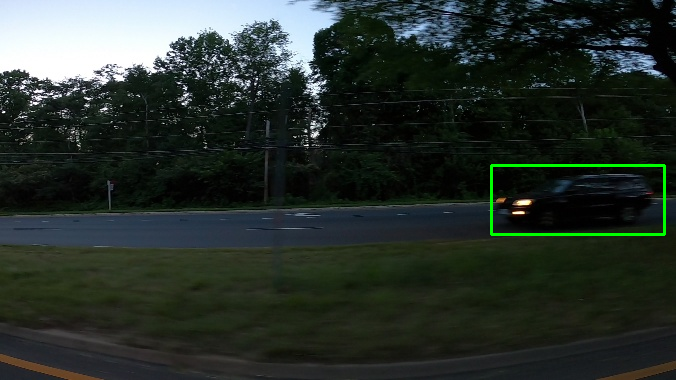

In [83]:
# Rastgele test görseli seç
idx = random.randint(0, len(os.listdir(test_data_path)) - 1)
image_name = os.listdir(test_data_path)[idx]
image_path = os.path.join(test_data_path, image_name)

# Görseli yükle
img = Image.open(image_path)

# Modelle tahmin yap
results = model(img)

for result in results:
    boxes = result.boxes
    bboxes = []

    for box in boxes:
        box = box.cpu()
        xyxy = box.xyxy.numpy()
        bboxes.append(tuple(xyxy[0]))

        confidence = box.conf.numpy()
        print(f"Bounding Box: {xyxy}")
        print(f"Confidence: {confidence}")

    # Görseli bounding box ile çiz
    display_image_with_bbox(image_path, bboxes if bboxes else None)
